In [1]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit, TimeSeriesSplit
import matplotlib.pyplot as plt
import xgboost as xgb
from scipy.special import logit, expit
from sklearn.metrics import confusion_matrix, classification_report
import shap
shap.initjs()

pd.set_option('max_columns',None)
pd.set_option('display.max_rows', 200)
tqdm.pandas()

# Import pickle file with features

In [3]:
df = pd.read_pickle('./data/export_features_2016_2018.pkl.bz2')

In [4]:
df_orig = df.copy() # save all data for later

In [5]:
df=df_orig # get all data back

In [6]:
all_features = ['location_count', 'location_mean', 'location_std',
 'location_min', 'location_5%', 'location_10%', 'location_15%',
 'location_20%', 'location_25%', 'location_30%', 'location_35%',
 'location_40%', 'location_45%', 'location_50%', 'location_55%',
 'location_60%', 'location_65%', 'location_70%', 'location_75%',
 'location_80%', 'location_85%', 'location_90%', 'location_95%',
 'location_max', 
                
 'band_count', 'band_mean', 'band_std',
 'band_min', 'band_5%', 'band_10%', 'band_15%', 'band_20%',
 'band_25%', 'band_30%', 'band_35%', 'band_40%', 'band_45%',
 'band_50%', 'band_55%', 'band_60%', 'band_65%', 'band_70%',
 'band_75%', 'band_80%', 'band_85%', 'band_90%', 'band_95%',
 'band_max', 
                
 'promoter_count', 'promoter_mean', 'promoter_std',
 'promoter_min', 'promoter_5%', 'promoter_10%', 'promoter_15%',
 'promoter_20%', 'promoter_25%', 'promoter_30%', 'promoter_35%',
 'promoter_40%', 'promoter_45%', 'promoter_50%', 'promoter_55%',
 'promoter_60%', 'promoter_65%', 'promoter_70%', 'promoter_75%',
 'promoter_80%', 'promoter_85%', 'promoter_90%', 'promoter_95%',
 'promoter_max', 
 
 'vg_datum_year', 'vg_datum_month', 'vg_datum_day_of_week',
                
 'location_kirche', 'location_theater', 'location_hotel', 'location_cafe',
 'location_stadthalle', 'location_buergerhaus', 'location_club', 'location_gaststaette',
 'location_halle', 'location_schloss', 'location_festhalle', 'location_musikschule',
 'location_restaurant', 'location_kulturzentrum', 'location_kurhaus',
 'location_festzelt', 'location_mehrzweckhalle', 'location_pub',
 'location_gasthaus', 'location_bar', 'location_turnhalle', 'location_klinik',
 'location_gymnasium', 'location_kulturhaus', 'location_rathaus', 'location_gasthof',
 'location_park', 'location_schuetzenhalle', 'location_hochschule', 'location_gemeindehalle',
                
 'band_musikverein', 'band_band', 'band_mv', 'band_duo', 'band_trio', 'band_musikkapelle',
 'band_chor', 'band_blaskapelle', 'band_stadtkapelle', 'band_gbr', 'band_orchester',
 'band_jazz', 'band_blasorchester', 'band_original', 'band_partyband', 'band_kurorchester',
 'band_friends', 'band_ensemble', 'band_blues', 'band_ev', 'band_swing', 'band_live',
 'band_musikzug', 'band_solo', 'band_sound', 'band_jugendkapelle', 'band_alleinunterhalter',
 'band_musikanten', 'band_harmonie', 'band_spielmannszug']

Drop segments 1 and 13, since data in those segments is not relevant for us

Drop data before 2014, since data before 2014 is noisy

In [7]:
df=df.loc[~df.amount_segment.isin([1,13]),['amount', 'amount_segment']+all_features]
df = df[df['vg_datum_year'] >= 2014]
df=df.dropna(subset=['amount_segment'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2064687 entries, 9938765 to 12490213
Columns: 137 entries, amount to band_spielmannszug
dtypes: float64(74), int64(63)
memory usage: 2.1 GB


# Get sample of the data

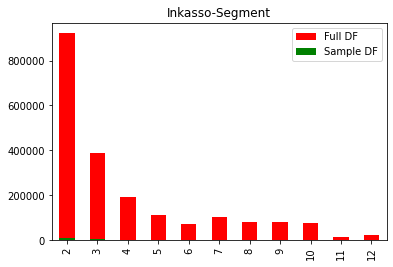

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20647 entries, 11295171 to 11879226
Columns: 137 entries, amount to band_spielmannszug
dtypes: float64(74), int64(63)
memory usage: 21.7 MB


In [12]:
#Get a sample of the DataFrame 
splitSample = StratifiedShuffleSplit(n_splits=1, test_size=0.01, random_state=42)

for train_idx, test_idx in splitSample.split(df[all_features], df.amount_segment):
    df_sample=df.iloc[test_idx]
    
    plt.figure()
    df.amount_segment.astype(int).value_counts().sort_index().plot.bar(color='r')
    df_sample.amount_segment.astype(int).value_counts().sort_index().plot.bar(color='g')

    plt.title('Inkasso-Segment')
    plt.legend(['Full DF', 'Sample DF'])
    plt.show()

df=df_sample.copy()
df.info()

# Define Models

In [8]:
#Classification
clf1 = xgb.XGBClassifier(n_estimators=500, max_depth=7, use_label_encoder=False, objective='binary:logistic',eval_metric = 'error')
clf2 = xgb.XGBClassifier(n_estimators=500, max_depth=7, use_label_encoder=False, objective='binary:logistic',eval_metric = 'error')

#Regression
reg2 = xgb.XGBRegressor(n_estimators=700, max_depth=7, min_child_weight=5, objective='reg:squarederror')
reg2_logit = xgb.XGBRegressor(n_estimators=700, max_depth=7, min_child_weight=5, objective='reg:squarederror')

reg3 = xgb.XGBRegressor(n_estimators=700, max_depth=7, min_child_weight=5, objective='reg:squarederror')
reg3_logit = xgb.XGBRegressor(n_estimators=700, max_depth=7, min_child_weight=5, objective='reg:squarederror')

# Prepare DataFrame for Classification Model

We keep only features + 'amount' and 'amount_segment' columns.

Encode segments for Classifier 1:
* Variable y_clf1 
* Positive class (seg 4+) y_clf1=1
* Negative class (seg 2 or 3) y_clf1=0

Encode segments for Classifier 2: 
* Variable y_clf2
* Positive class (seg 3) y_clf2=1
* Negative class (seg 2) y_clf2=0
* Segments >3 are "encoded" as np.NaN. These NaN values will be dropped before training

In [9]:
df.loc[:,'y_clf1']=(df.amount_segment.astype(int) > 3).values.astype(int)
df.loc[:,'y_clf2']=df.amount_segment.apply(lambda x: 1 if x==3 else (0 if x==2 else np.nan))

# Train and Test Classification Models

In oder to have larger train and test sets, we use crossvalidation-like approach to verify the model performance.
1. We split the dataset into 5 folds with StratifiedKFold. The criteria for split is to have the same proportion of data based on the segment in each fold.
2. In each fold we train and test both classifiers independently from each other
3. We save the predict_proba results from both classifiers
4. Train and test iteration numbers are also saved (in case we want to evaluate the results based on the train/test iteration

In [10]:
#skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_model_eval = TimeSeriesSplit(n_splits=5)

df['y_pred_proba_clf1']=np.NaN
df['y_pred_proba_clf2']=np.NaN
df["y_pred_reg2"]=np.NaN
df["y_pred_reg2_logit"]=np.NaN
df["y_pred_reg3"]=np.NaN
df["y_pred_reg3_logit"]=np.NaN

df['train_iter']=np.NaN
df['test_iter']=np.NaN

iter_nr=0

for train_idx, test_idx in tqdm(cv_model_eval.split(df[all_features], df.amount_segment), total=cv_model_eval.n_splits):
    
    df_train=df.iloc[train_idx]
    df_test=df.iloc[test_idx]
    
    #Test dataset is the same for all models
    X_test = df_test[all_features]
    y_test_clf1=df_test.y_clf1
    
    X_train_clf1 = df_train[all_features]
    y_train_clf1 = df_train.y_clf1

    # For Classifier2 (clf2) we use data from segments 2 and 3 (so we drop records where y_clf2 is NaN)
    df_train_clf2 = df_train.dropna(subset=['y_clf2'])

    X_train_clf2 = df_train_clf2[all_features]
    y_train_clf2 = df_train_clf2.y_clf2
    
    y_test_clf2=df_test.y_clf2
    
    # For Regression seg2 use only Segment 2 and amount 0.00001>=amount>=49.9999 (because of logit)
    df_train_reg2 = df_train[(df_train['amount_segment']==2) & 
                             (df_train['amount']>=0.00001) & 
                             (df_train['amount']<=49.9999)]#.dropna().drop_duplicates()

    X_train_reg2 = df_train_reg2[all_features]
    y_train_reg2 = df_train_reg2.amount
    y_train_reg2_logit = (y_train_reg2/50).apply(logit)
    
    
    # For Regression seg3 use only Segment 3 and amount 50>amount>=99.9999 (because of logit)
    df_train_reg3 = df_train[(df_train['amount_segment']==3) & 
                             (df_train['amount']>50) & 
                             (df_train['amount']<=99.9999)]#.dropna().drop_duplicates()

    X_train_reg3 = df_train_reg3[all_features]
    y_train_reg3 = df_train_reg3.amount
    y_train_reg3_logit = ((y_train_reg3-50)/50).apply(logit)
    
        
  
    #Fit and test the models
    
    #Classifier 1
    clf1.fit(X_train_clf1, y_train_clf1)
    y_pred_proba_clf1 = clf1.predict_proba(X_test)[:, 1]
    print("CLF1 Train Error: {}".format(clf1.score(X_train_clf1, y_train_clf1)))
    print("CLF1 Test Error: {}".format(clf1.score(X_test, y_test_clf1)))
    
    #Classifier 2        
    clf2.fit(X_train_clf2, y_train_clf2)
    y_pred_proba_clf2 = clf2.predict_proba(X_test)[:, 1]
    print("CLF2 Train Error: {}".format(clf2.score(X_train_clf2, y_train_clf2)))
    print("CLF2 Test Error: {}".format(clf2.score(df_test.dropna(subset=['y_clf2'])[all_features], df_test.dropna(subset=['y_clf2']).y_clf2)))
    
    
    #Regression Segment 2
    reg2.fit(X_train_reg2, y_train_reg2)
    y_pred_reg2=reg2.predict(X_test)
    print("REG2 Train Error: {}".format(reg2.score(X_train_reg2, y_train_reg2)))
    print("REG2 Test Error: {}".format(reg2.score(df_test[df_test.amount_segment==2][all_features], df_test[df_test.amount_segment==2].amount)))

    #Regression Segment 2 with logit transformation
    reg2_logit.fit(X_train_reg2, y_train_reg2_logit)
    y_pred_reg2_logit = reg2_logit.predict(X_test)
    y_pred_reg2_logit_transf = pd.Series(y_pred_reg2_logit).apply(expit)*50
    print("REG2_Logit Train Error: {}".format(reg2_logit.score(X_train_reg2, y_train_reg2_logit)))
    print("REG2_Logit Test Error: {}".format(reg2_logit.score(df_test[(df_test.amount_segment==2)& 
                                                             (df_test.amount>=0.00001) & 
                                                             (df_test.amount<=49.9999)][all_features], 
                                                             (df_test[(df_test.amount_segment==2)& 
                                                             (df_test.amount>=0.00001) & 
                                                             (df_test.amount<=49.9999)
                                                                     ].amount/50).apply(logit))))

    
    #Regression Segment 3
    reg3.fit(X_train_reg3, y_train_reg3)
    y_pred_reg3=reg3.predict(X_test)
    print("REG3 Train Error: {}".format(reg3.score(X_train_reg3, y_train_reg3)))
    print("REG3 Test Error: {}".format(reg3.score(df_test[df_test.amount_segment==3][all_features], df_test[df_test.amount_segment==3].amount)))


    #Regression Segment 3 with logit transformation
    reg3_logit.fit(X_train_reg3, y_train_reg3_logit)
    y_pred_reg3_logit = reg3_logit.predict(X_test)
    y_pred_reg3_logit_transf = pd.Series(y_pred_reg3_logit).apply(expit)*50+50
    print("REG3_Logit Train Error: {}".format(reg3_logit.score(X_train_reg3, y_train_reg3_logit)))
    print("REG3_Logit Test Error: {}".format(reg3_logit.score(df_test[(df_test['amount_segment']==3) & 
                                                                      (df_test['amount']>50) & 
                                                                      (df_test['amount']<=99.9999)][all_features], 
                                                        ((df_test[(df_test['amount_segment']==3) & 
                                                                  (df_test['amount']>50) & 
                                                                  (df_test['amount']<=99.9999)].amount-50)/50).apply(logit))))
    
    
    #Save the prediction results in separate columns
    df.iloc[test_idx,df.columns.get_loc("y_pred_proba_clf1")]=y_pred_proba_clf1
    df.iloc[test_idx,df.columns.get_loc("y_pred_proba_clf2")]=y_pred_proba_clf2
    df.iloc[test_idx,df.columns.get_loc("y_pred_reg2")]=y_pred_reg2
    df.iloc[test_idx,df.columns.get_loc("y_pred_reg2_logit")]=y_pred_reg2_logit_transf
    df.iloc[test_idx,df.columns.get_loc("y_pred_reg3")]=y_pred_reg3
    df.iloc[test_idx,df.columns.get_loc("y_pred_reg3_logit")]=y_pred_reg3_logit_transf
    
    #Save train and test iteration number, in case we need it later 
    #(not sure if one record can be multiple times in train/test, anyway we save only the last iteration number for now...)
    df.iloc[train_idx,df.columns.get_loc("train_iter")]=iter_nr
    df.iloc[test_idx,df.columns.get_loc("test_iter")]=iter_nr
    
    iter_nr=iter_nr+1

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


CLF1 Train Error: 0.9813290247212431


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


CLF1 Test Error: 0.9323915911587439


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


CLF2 Train Error: 0.978321747586803


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


CLF2 Test Error: 0.9307076348452682


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


REG2 Train Error: 0.9189099447053911


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


REG2 Test Error: 0.7851595763069217


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


REG2_Logit Train Error: 0.913603897483443


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


REG2_Logit Test Error: 0.7528466881326533


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


REG3 Train Error: 0.9511856782973984


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


REG3 Test Error: 0.6747197760329035


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


REG3_Logit Train Error: 0.9498280956233416


Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


REG3_Logit Test Error: 0.6595697082980061


 20%|████████████████                                                                | 1/5 [39:37<2:38:31, 2377.85s/it]


MemoryError: Unable to allocate 216. MiB for an array with shape (63, 449150) and data type int64

Check if all records were used in train/test (was not the case with StratifiedShuffleSplit)

In [21]:
df[['train_iter', 'test_iter']].isnull().sum()

train_iter    3441
test_iter     3442
dtype: int64

Visualisation of train/test split for each fold

<AxesSubplot:title={'center':'TimeSeriesSplit'}, xlabel='Sample index', ylabel='CV iteration'>

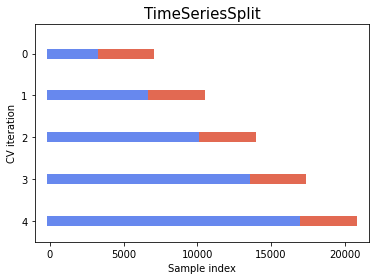

In [22]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits, -.2])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
fig, ax = plt.subplots()
plot_cv_indices(cv_model_eval, df[all_features], df.amount_segment, ax, cv_model_eval.n_splits)

# Threshold optimization

In [23]:
df['y_pred_proba_clf1']=df['y_pred_proba_clf1'].apply(lambda x: format(float(x),".8f")).astype(float)
df['y_pred_proba_clf2']=df['y_pred_proba_clf2'].apply(lambda x: format(float(x),".8f")).astype(float)

In [24]:
cv_treasholds = TimeSeriesSplit(n_splits=5)

## Threshold optimization (clf1)

We optimize only t_neg threshold since for clf1 only positive class is of importance. We want to prevent classification of segments 4+ as segments 2 or 3 since this will mean "lost money".

In [25]:
#Define Thresholds (t_neg and t_pos) We want to minimize False Negative and False Positive
#max_for_clf1 = 0.03 # False Omission Rate

#opt_t_neg_list_clf1 = []

max_for_clf1_list = [0.01, 0.03, 0.05, 0.07, 0.09]
opt_t_neg_list_clf1 = pd.DataFrame()

#Use all features, encode segment 4+ as positive class, otherwise negative
X_train_clf1 = df[all_features]
y_train_clf1= df.y_clf1

for i in tqdm(range(5)):
    # we use all data for threshold optimization
    for train_idx, test_idx in tqdm(cv_treasholds.split(X_train_clf1, y_train_clf1), total=cv_treasholds.n_splits) : 
        
        clf1.fit(X_train_clf1.iloc[train_idx], y_train_clf1.iloc[train_idx])
        
        y_test_pred_proba_clf1 = clf1.predict_proba(X_train_clf1.iloc[test_idx])[:, 1]
        y_test_clf1 = y_train_clf1.iloc[test_idx]
        
        opt_t_neg_clf1 = 0
        opt_fnr_clf1 = 0
        
        for max_for_clf1 in max_for_clf1_list :
            for t_neg_clf1 in np.linspace(0, 1, 1001):
                for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
                if for_clf1 > max_for_clf1:
                    break
                opt_t_neg_clf1 = t_neg_clf1
                opt_for_clf1 = for_clf1

            print(opt_t_neg_clf1, opt_for_clf1, max_for_clf1)
            opt_t_neg_list_clf1 = opt_t_neg_list_clf1.append({"max_for_clf1": max_for_clf1, "opt_t_neg_clf1": opt_t_neg_clf1}, ignore_index=True)

for max_for_clf1 in max_for_clf1_list :
    print('max_for_clf1 = {}'.format(max_for_clf1))
    display(opt_t_neg_list_clf1[opt_t_neg_list_clf1.max_for_clf1==max_for_clf1].opt_t_neg_clf1.describe())

classifier_thresholds_clf1 = pd.DataFrame()
for max_for_clf1 in max_for_clf1_list :
    #t_neg = min(opt_t_neg_list)
    t_neg_clf1 = np.median(opt_t_neg_list_clf1[opt_t_neg_list_clf1.max_for_clf1==max_for_clf1].opt_t_neg_clf1)

    classifier_thresholds_clf1 = classifier_thresholds_clf1.append({"max_for_clf1": max_for_clf1,
        "t_neg_clf1": t_neg_clf1}, ignore_index=True)

display(classifier_thresholds_clf1)



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-inpu

0.0 nan 0.01
0.004 0.029339853300733496 0.03
0.034 0.049893842887473464 0.05
0.15 0.06965416463711642 0.07



 20%|████████████████▊                                                                   | 1/5 [00:08<00:34,  8.58s/it]

0.45 0.08977900552486189 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.0 nan 0.01
0.005 0.028372900984365953 0.03
0.035 0.04961240310077519 0.05
0.212 0.06960227272727272 0.07



 40%|█████████████████████████████████▌                                                  | 2/5 [00:29<00:47, 15.69s/it]

0.5720000000000001 0.08989266547406083 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.0 nan 0.01
0.003 0.02872531418312388 0.03
0.026000000000000002 0.05 0.05
0.139 0.06999041227229147 0.07
0.42 0.08979591836734693 0.09



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:04<00:49, 24.52s/it]c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= 

0.0 nan 0.01
0.02 0.02958904109589041 0.03
0.11 0.0499001996007984 0.05
0.369 0.06960556844547564 0.07


<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:51<00:33, 33.53s/it]

0.711 0.08974358974358974 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()


0.001 0.007902298850574713 0.01
0.016 0.029714285714285714 0.03
0.07 0.049922799794132784 0.05


<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()


0.226 0.06957773512476008 0.07



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.47200000000000003 0.08970856102003642 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.0 nan 0.01
0.004 0.029339853300733496 0.03
0.034 0.049893842887473464 0.05
0.15 0.06965416463711642 0.07



 20%|████████████████▊                                                                   | 1/5 [00:10<00:40, 10.18s/it]

0.45 0.08977900552486189 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.0 nan 0.01
0.005 0.028372900984365953 0.03
0.035 0.04961240310077519 0.05
0.212 0.06960227272727272 0.07



 40%|█████████████████████████████████▌                                                  | 2/5 [00:39<01:04, 21.38s/it]

0.5720000000000001 0.08989266547406083 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.0 nan 0.01
0.003 0.02872531418312388 0.03
0.026000000000000002 0.05 0.05
0.139 0.06999041227229147 0.07



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:11<00:52, 26.35s/it]

0.42 0.08979591836734693 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.0 nan 0.01
0.02 0.02958904109589041 0.03
0.11 0.0499001996007984 0.05
0.369 0.06960556844547564 0.07


<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:58<00:34, 34.35s/it]

0.711 0.08974358974358974 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.001 0.007902298850574713 0.01
0.016 0.029714285714285714 0.03
0.07 0.049922799794132784 0.05
0.226 0.06957773512476008 0.07



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.47200000000000003 0.08970856102003642 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.0 nan 0.01
0.004 0.029339853300733496 0.03
0.034 0.049893842887473464 0.05
0.15 0.06965416463711642 0.07
0.45 0.08977900552486189 0.09


 20%|████████████████▊                                                                   | 1/5 [00:08<00:32,  8.19s/it]c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t

0.0 nan 0.01
0.005 0.028372900984365953 0.03
0.035 0.04961240310077519 0.05
0.212 0.06960227272727272 0.07



 40%|█████████████████████████████████▌                                                  | 2/5 [00:29<00:47, 15.76s/it]

0.5720000000000001 0.08989266547406083 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.0 nan 0.01
0.003 0.02872531418312388 0.03
0.026000000000000002 0.05 0.05
0.139 0.06999041227229147 0.07



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:05<00:50, 25.20s/it]

0.42 0.08979591836734693 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.0 nan 0.01
0.02 0.02958904109589041 0.03
0.11 0.0499001996007984 0.05
0.369 0.06960556844547564 0.07


<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:54<00:34, 34.62s/it]

0.711 0.08974358974358974 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.001 0.007902298850574713 0.01
0.016 0.029714285714285714 0.03
0.07 0.049922799794132784 0.05
0.226 0.06957773512476008 0.07


<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.47200000000000003 0.08970856102003642 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.0 nan 0.01
0.004 0.029339853300733496 0.03
0.034 0.049893842887473464 0.05
0.15 0.06965416463711642 0.07



 20%|████████████████▊                                                                   | 1/5 [00:13<00:53, 13.42s/it]

0.45 0.08977900552486189 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.0 nan 0.01
0.005 0.028372900984365953 0.03
0.035 0.04961240310077519 0.05
0.212 0.06960227272727272 0.07


<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()

 40%|█████████████████████████████████▌                                                  | 2/5 [00:36<00:56, 18.86s/it]

0.5720000000000001 0.08989266547406083 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.0 nan 0.01
0.003 0.02872531418312388 0.03
0.026000000000000002 0.05 0.05
0.139 0.06999041227229147 0.07



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:13<00:54, 27.22s/it]

0.42 0.08979591836734693 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.0 nan 0.01
0.02 0.02958904109589041 0.03
0.11 0.0499001996007984 0.05
0.369 0.06960556844547564 0.07


<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:00<00:35, 35.06s/it]

0.711 0.08974358974358974 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.001 0.007902298850574713 0.01
0.016 0.029714285714285714 0.03
0.07 0.049922799794132784 0.05
0.226 0.06957773512476008 0.07



  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

0.47200000000000003 0.08970856102003642 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.0 nan 0.01
0.004 0.029339853300733496 0.03
0.034 0.049893842887473464 0.05
0.15 0.06965416463711642 0.07



 20%|████████████████▊                                                                   | 1/5 [00:10<00:41, 10.47s/it]

0.45 0.08977900552486189 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.0 nan 0.01
0.005 0.028372900984365953 0.03
0.035 0.04961240310077519 0.05
0.212 0.06960227272727272 0.07


<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()

 40%|█████████████████████████████████▌                                                  | 2/5 [00:35<00:56, 18.85s/it]

0.5720000000000001 0.08989266547406083 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.0 nan 0.01
0.003 0.02872531418312388 0.03
0.026000000000000002 0.05 0.05
0.139 0.06999041227229147 0.07



 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:12<00:54, 27.08s/it]

0.42 0.08979591836734693 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.0 nan 0.01
0.02 0.02958904109589041 0.03
0.11 0.0499001996007984 0.05
0.369 0.06960556844547564 0.07


<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:03<00:36, 36.89s/it]

0.711 0.08974358974358974 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_clf1 = (y_test_pred_proba_clf1[y_test_clf1 == 1] <= t_neg_clf1).sum() / (y_test_pred_proba_clf1 <= t_neg_clf1).sum()
<ipython-input-25-1cd871474e05>:27: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.001 0.007902298850574713 0.01
0.016 0.029714285714285714 0.03
0.07 0.049922799794132784 0.05
0.226 0.06957773512476008 0.07



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [14:50<00:00, 178.07s/it]

0.47200000000000003 0.08970856102003642 0.09
max_for_clf1 = 0.01


count    25.000000
mean      0.000200
std       0.000408
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       0.001000
Name: opt_t_neg_clf1, dtype: float64

max_for_clf1 = 0.03


count    25.000000
mean      0.009600
std       0.007147
min       0.003000
25%       0.004000
50%       0.005000
75%       0.016000
max       0.020000
Name: opt_t_neg_clf1, dtype: float64

max_for_clf1 = 0.05


count    25.000000
mean      0.055000
std       0.032055
min       0.026000
25%       0.034000
50%       0.035000
75%       0.070000
max       0.110000
Name: opt_t_neg_clf1, dtype: float64

max_for_clf1 = 0.07


count    25.000000
mean      0.219200
std       0.083863
min       0.139000
25%       0.150000
50%       0.212000
75%       0.226000
max       0.369000
Name: opt_t_neg_clf1, dtype: float64

max_for_clf1 = 0.09


count    25.000000
mean      0.525000
std       0.108267
min       0.420000
25%       0.450000
50%       0.472000
75%       0.572000
max       0.711000
Name: opt_t_neg_clf1, dtype: float64

,max_for_clf1,t_neg_clf1
0,0.01,0.000
1,0.03,0.005
2,0.05,0.035
3,0.07,0.212
4,0.09,0.472


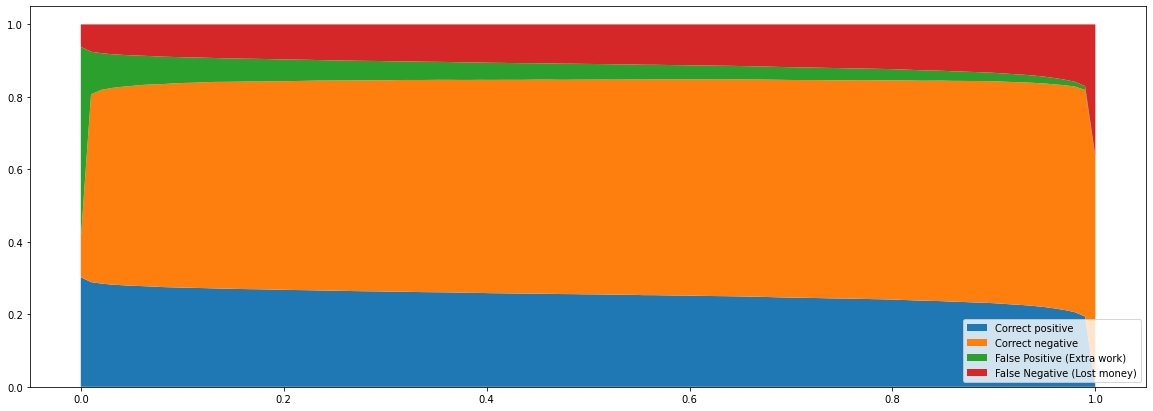

In [28]:
def create_conf_matrix_clf1(t_neg):
    df['y_pred_clf1']=df['y_pred_proba_clf1'].apply(lambda x: 1 if x >= t_neg else 0) 
    df_confusion_clf1 = pd.DataFrame(confusion_matrix(df.y_clf1, df.y_pred_clf1), index=['true neg (2,3)', 'true pos (4+)'], columns=['pred. neg (2,3)', 'pred. pos (4+)'])

    return df_confusion_clf1

correct_positive=[]
correct_negative=[]
false_positive=[]
false_negative=[]


for v in np.linspace(0, 1, 100):
    result = create_conf_matrix_clf1(v)
    
    correct_positive.append(result.iloc[1,1]/df.shape[0])
    correct_negative.append(result.iloc[0,0]/df.shape[0])
    false_positive.append(result.iloc[0,1]/df.shape[0])    
    false_negative.append(result.iloc[1,0]/df.shape[0])
    
    #print('Threshold = {}'.format(v))
    #print(result)
    
x=np.linspace(0, 1, 100)
plt.figure(figsize=(20,7))


plt.stackplot(x,correct_positive, correct_negative, false_positive, false_negative, 
              labels=['Correct positive', 
                      'Correct negative',
                      'False Positive (Extra work)', 
                      'False Negative (Lost money)'])
plt.legend(loc='lower right')

## Threshold optimization (clf2)

Both segment 2 (negative class) and segment 3 (positive class) are equally important --> we need both t_neg and t_pos

In [30]:
#Define Thresholds (t_neg and t_pos) We want to minimize False Negative and False Positive
#max_for_clf2 = 0.05 #False omission rate
#max_fdr_clf2 = 0.05 #False discovery rate
max_for_clf2_list = [0.01, 0.03, 0.05, 0.07, 0.09]
max_fdr_clf2_list = [0.01, 0.03, 0.05, 0.07, 0.09]

opt_t_neg_list_clf2 = pd.DataFrame()
opt_t_pos_list_clf2 = pd.DataFrame()

#Use only data records from seg. 2 and 3. Use all features. 
X_train_clf2 = df[~df.y_clf2.isnull()][all_features]
#Encode segment 3 as 1 (positive class), seg. 2 as 0 (negative class)
y_train_clf2= df[~df.y_clf2.isnull()].y_clf2

for i in tqdm(range(5)):
    for train_idx, test_idx in tqdm(cv_treasholds.split(X_train_clf2, y_train_clf2), total=cv_treasholds.n_splits) : 
        clf2.fit(X_train_clf2.iloc[train_idx], y_train_clf2.iloc[train_idx])
        
        y_test_pred_proba_clf2 = clf2.predict_proba(X_train_clf2.iloc[test_idx])[:, 1]
        y_test_clf2 = y_train_clf2.iloc[test_idx]
        
        for max_for_clf2 in max_for_clf2_list :
            opt_t_neg_clf2 = 0
            opt_for_clf2 = 0
            for t_neg_clf2 in np.linspace(0, 1, 1001):
                for_clf2 = (y_test_pred_proba_clf2[y_test_clf2 == 1] <= t_neg_clf2).sum() / (y_test_pred_proba_clf2 <= t_neg_clf2).sum()
                if for_clf2 > max_for_clf2:
                    break
                opt_t_neg_clf2 = t_neg_clf2
                opt_for_clf2 = for_clf2

            print(opt_t_neg_clf2, opt_for_clf2, max_for_clf2)
            opt_t_neg_list_clf2 = opt_t_neg_list_clf2.append({"max_for_clf2": max_for_clf2, "opt_t_neg_clf2": opt_t_neg_clf2}, ignore_index=True)


        for max_fdr_clf2 in max_fdr_clf2_list :
            opt_t_pos_clf2 = 0
            opt_fdr_clf2 = 0
            for t_pos_clf2 in np.linspace(0, 1, 1001):
                fdr_clf2 = (y_test_pred_proba_clf2[y_test_clf2 == 0] >= t_pos_clf2).sum() / (y_test_pred_proba_clf2 >= t_pos_clf2).sum()
                opt_t_pos_clf2 = t_pos_clf2
                opt_fdr_clf2 = fdr_clf2
                if fdr_clf2 <= max_fdr_clf2:
                    break
            print(opt_t_pos_clf2, opt_fdr_clf2, max_fdr_clf2)
            opt_t_pos_list_clf2 = opt_t_pos_list_clf2.append({"max_fdr_clf2": max_fdr_clf2, "opt_t_pos_clf2": opt_t_pos_clf2}, ignore_index=True)

for max_for_clf2 in max_for_clf2_list :
    print('max_for_clf2 = {}'.format(max_for_clf2))
    display(opt_t_neg_list_clf2[opt_t_neg_list_clf2.max_for_clf2==max_for_clf2].opt_t_neg_clf2.describe())

for max_fdr_clf2 in max_fdr_clf2_list :
    print('max_fdr_clf2 = {}'.format(max_fdr_clf2))
    display(opt_t_pos_list_clf2[opt_t_pos_list_clf2.max_fdr_clf2==max_fdr_clf2].opt_t_pos_clf2.describe())

classifier_thresholds_clf2 = pd.DataFrame()

for max_for_clf2 in max_for_clf2_list :
    t_neg_clf2 = np.median(opt_t_neg_list_clf2[opt_t_neg_list_clf2.max_for_clf2==max_for_clf2].opt_t_neg_clf2)

    classifier_thresholds_clf2 = classifier_thresholds_clf2.append({"max_for_clf2": max_for_clf2,
        "t_neg_clf2": t_neg_clf2}, ignore_index=True)

    
for max_fdr_clf2 in max_fdr_clf2_list :
    t_pos_clf2 = np.median(opt_t_pos_list_clf2)
    t_pos_clf2 = np.median(opt_t_pos_list_clf2[opt_t_pos_list_clf2.max_fdr_clf2==max_fdr_clf2].opt_t_pos_clf2)

    classifier_thresholds_clf2 = classifier_thresholds_clf2.append({"max_fdr_clf2": max_fdr_clf2,
        "t_pos_clf2": t_pos_clf2}, ignore_index=True)
    
display(classifier_thresholds_clf2)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-30-4c5aee8ce0da>:26: RuntimeWarning: invalid value encountered in long_scalars
  for_clf2 = (y_test_pred_proba_clf2[y_test_clf2 == 1] <= t_neg_clf2).sum() / (y_test_pred_proba_clf2 <= t_neg_clf2).sum()
<ipython-input-30-4c5aee8ce0da>:26: RuntimeWarning: invalid value encountered in long_scalars
  for_clf2 = (y_test_pred_proba_clf2[y_test_clf2 == 1] <= t_neg_clf2).sum() / (y_test_pred_proba_clf2 <= t_neg_clf2).sum()
<ipython-input-30-4c5aee8ce0da>:26: RuntimeWarning: invalid value encountered in long_scalars
  for_clf2 = (y_test_pred_proba_clf2[y_test_clf2 == 1] <= t_neg_clf2).sum() / (y_test_pred_proba_clf2 <= t

0.0 nan 0.01
0.001 0.029585798816568046 0.03
0.009000000000000001 0.04951560818083961 0.05
0.045 0.0692829457364341 0.07
0.132 0.08981233243967829 0.09


<ipython-input-30-4c5aee8ce0da>:40: RuntimeWarning: invalid value encountered in long_scalars
  fdr_clf2 = (y_test_pred_proba_clf2[y_test_clf2 == 0] >= t_pos_clf2).sum() / (y_test_pred_proba_clf2 >= t_pos_clf2).sum()


1.0 nan 0.01


<ipython-input-30-4c5aee8ce0da>:40: RuntimeWarning: invalid value encountered in long_scalars
  fdr_clf2 = (y_test_pred_proba_clf2[y_test_clf2 == 0] >= t_pos_clf2).sum() / (y_test_pred_proba_clf2 >= t_pos_clf2).sum()


1.0 nan 0.03


<ipython-input-30-4c5aee8ce0da>:40: RuntimeWarning: invalid value encountered in long_scalars
  fdr_clf2 = (y_test_pred_proba_clf2[y_test_clf2 == 0] >= t_pos_clf2).sum() / (y_test_pred_proba_clf2 >= t_pos_clf2).sum()


1.0 nan 0.05
0.997 0.06751054852320675 0.07



 20%|████████████████▊                                                                   | 1/5 [00:10<00:42, 10.54s/it]

0.989 0.08981001727115717 0.09


c:\users\mneumann\.virtualenvs\notebooks-cbf-nubn\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
<ipython-input-30-4c5aee8ce0da>:26: RuntimeWarning: invalid value encountered in long_scalars
  for_clf2 = (y_test_pred_proba_clf2[y_test_clf2 == 1] <= t_neg_clf2).sum() / (y_test_pred_proba_clf2 <= t_neg_clf2).sum()
<ipython-input-30-4c5aee8ce0da>:26: RuntimeWarning: invalid value encountered in long_scalars
  for_clf2 = (y_test_pred_proba_clf2[y_test_clf2 == 1] <= t_neg_clf2).sum() / (y_test_pred_proba_clf2 <= t_neg_clf2).sum()
<ipython-input-30-4c5aee8ce0da>:26: RuntimeWarning: invalid value encountered in long_scalars
  for_clf2 = (y_test_pred_proba_clf2[y_test_clf2 == 1] <= t_neg_clf2).sum() / (y_test_pred_proba_clf2 <= t_neg_clf2).sum()
<ipython-input-30-4c5aee8ce0da>:26: RuntimeWarning: invalid value encountered in long_scalars
  for_cl

0.0 nan 0.01
0.001 0.025506867233485938 0.03
0.01 0.04924831518921721 0.05
0.037 0.06912657636618402 0.07
0.121 0.08996539792387544 0.09


<ipython-input-30-4c5aee8ce0da>:40: RuntimeWarning: invalid value encountered in long_scalars
  fdr_clf2 = (y_test_pred_proba_clf2[y_test_clf2 == 0] >= t_pos_clf2).sum() / (y_test_pred_proba_clf2 >= t_pos_clf2).sum()


1.0 nan 0.01


<ipython-input-30-4c5aee8ce0da>:40: RuntimeWarning: invalid value encountered in long_scalars
  fdr_clf2 = (y_test_pred_proba_clf2[y_test_clf2 == 0] >= t_pos_clf2).sum() / (y_test_pred_proba_clf2 >= t_pos_clf2).sum()


1.0 nan 0.03
0.998 0.04909560723514212 0.05
0.996 0.0684931506849315 0.07



 40%|█████████████████████████████████▌                                                  | 2/5 [00:32<00:51, 17.26s/it]

0.987 0.08795411089866156 0.09


  0%|                                                                                            | 0/5 [01:09<?, ?it/s]


IndexError: positional indexers are out-of-bounds

# Create combined confusion matrix

In [31]:
max_for_clf1 = 0.03
max_for_clf2 = 0.05 #False omission rate
max_fdr_clf2 = 0.05 #False discovery rate

t_neg_clf1=classifier_thresholds_clf1[classifier_thresholds_clf1.max_for_clf1==max_for_clf1].t_neg_clf1.values[0]

t_neg_clf2=classifier_thresholds_clf2[classifier_thresholds_clf2.max_for_clf2==max_for_clf2].t_neg_clf2.values[0]
t_pos_clf2=classifier_thresholds_clf2[classifier_thresholds_clf2.max_fdr_clf2==max_fdr_clf2].t_pos_clf2.values[0]

#t_neg_clf2=classifier_thresholds_clf2['t_neg_clf2']
#t_pos_clf2=classifier_thresholds_clf2['t_pos_clf2']

#remove entries with no predictions
df=df.dropna(subset=['test_iter'])


df['y']=df.amount_segment.apply(lambda x: '2' if x==2 else ('3' if x==3 else '4+'))

df['y_pred_clf1']=df['y_pred_proba_clf1'].apply(lambda x: '2 or 3' if x <= t_neg_clf1 else '4+')
df['y_pred_clf2']=df['y_pred_proba_clf2'].apply(lambda x: '2' if x<=t_neg_clf2 else 
                                                ('2?' if x<=0.5 else 
                                                 ('3?' if x<=t_pos_clf2 else '3')))

df['y_pred']=df.apply(lambda x: x['y_pred_clf1'] if x['y_pred_clf1']=='4+' else x['y_pred_clf2'], axis=1)

In [32]:
df[['amount_segment', 'y','y_pred_proba_clf1','y_pred_clf1', 'y_pred_proba_clf2', 'y_pred_clf2', 'y_pred']]

,amount_segment,y,y_pred_proba_clf1,y_pred_clf1,y_pred_proba_clf2,y_pred_clf2,y_pred
ID,,,,,,,
11295171,11.0,4+,NaN,4+,NaN,3,4+
10648579,7.0,4+,NaN,4+,NaN,3,4+
10067023,2.0,2,NaN,4+,NaN,3,4+
10805312,5.0,4+,NaN,4+,NaN,3,4+
10333800,3.0,3,NaN,4+,NaN,3,4+
...,...,...,...,...,...,...,...
10774010,10.0,4+,0.999997,4+,0.846464,3?,4+
10906884,6.0,4+,0.993126,4+,0.122062,2?,4+
11958692,4.0,4+,0.083350,4+,0.999248,3,4+


In [33]:
df_confusion_comb = pd.DataFrame(confusion_matrix(df.y, df.y_pred, 
                                                  labels=['2','2?','3?','3','4+']), 
                                 index=['true 2', 'true 2?', 'true 3?', 'true 3', 'true 4+'], 
                                 columns=['pred 2', 'pred 2?', 'pred 3?', 'pred 3', 'pred 4+'])
print('Abs. Numbers')
df_confusion_comb.drop(index=['true 2?', 'true 3?'])

Abs. Numbers


,pred 2,pred 2?,pred 3?,pred 3,pred 4+
true 2,5603,411,219,84,2914
true 3,289,207,289,1079,2031
true 4+,95,38,39,47,7302


In [34]:
df_confusion_comb = pd.DataFrame(confusion_matrix(df.y, df.y_pred, 
                                                  labels=['2','2?','3?','3','4+'], normalize="true"), 
                                 index=['true 2', 'true 2?', 'true 3?', 'true 3', 'true 4+'], 
                                 columns=['pred 2', 'pred 2?', 'pred 3?', 'pred 3', 'pred 4+'])
print('Rel. to true count per class in %')
(df_confusion_comb.drop(index=['true 2?', 'true 3?']) * 100).round(1)

Rel. to true count per class in %


,pred 2,pred 2?,pred 3?,pred 3,pred 4+
true 2,60.7,4.5,2.4,0.9,31.6
true 3,7.4,5.3,7.4,27.7,52.1
true 4+,1.3,0.5,0.5,0.6,97.1


In [35]:
print('Classification Report')
print(classification_report(df.y, df.y_pred, labels=['2','2?','3?','3','4+'],zero_division=0))

Classification Report
              precision    recall  f1-score   support

           2       0.94      0.61      0.74      9231
          2?       0.00      0.00      0.00         0
          3?       0.00      0.00      0.00         0
           3       0.89      0.28      0.42      3895
          4+       0.60      0.97      0.74      7521

    accuracy                           0.68     20647
   macro avg       0.48      0.37      0.38     20647
weighted avg       0.80      0.68      0.68     20647



# Get scores for regressions (with correct class)

In [36]:
df_reg2 = df[df.amount_segment==2].copy()
df_reg2['discr'] = df.amount-df.y_pred_reg2
df_reg2['discr_abs'] = abs(df.amount-df.y_pred_reg2)
df_reg2['discr_logit'] = df.amount-df.y_pred_reg2_logit
df_reg2['discr_logit_abs'] = abs(df.amount-df.y_pred_reg2_logit)

df_reg3 = df[df.amount_segment==3].copy()
df_reg3['discr'] = df.amount-df.y_pred_reg3
df_reg3['discr_abs'] = abs(df.amount-df.y_pred_reg3)
df_reg3['discr_logit'] = df.amount-df.y_pred_reg3_logit
df_reg3['discr_logit_abs'] = abs(df.amount-df.y_pred_reg3_logit)

In [38]:
print('Discrepancy reg2')
print(df_reg2.discr.describe())
print('')
print('Absolute discrepancy reg2')
print(df_reg2.discr_abs.describe())
print('')
print('Discrepancy reg2_logit')
print(df_reg2.discr_logit.describe())
print('')
print('Absolute discrepancy reg2_logit')
print(df_reg2.discr_logit_abs.describe())

Discrepancy reg2
count    7699.000000
mean       -0.102219
std         7.387689
min       -32.466934
25%        -3.265230
50%        -0.228491
75%         2.045468
max        36.278442
Name: discr, dtype: float64

Absolute discrepancy reg2
count    7699.000000
mean        4.905722
std         5.524415
min         0.000003
25%         0.847392
50%         2.737507
75%         7.139249
max        36.278442
Name: discr_abs, dtype: float64

Discrepancy reg2_logit
count    7699.000000
mean       -0.920451
std         7.834412
min       -33.504132
25%        -4.057946
50%        -0.324584
75%         1.743751
max        35.494749
Name: discr_logit, dtype: float64

Absolute discrepancy reg2_logit
count    7699.000000
mean        5.209990
std         5.922653
min         0.000027
25%         0.870232
50%         2.911530
75%         7.524676
max        35.494749
Name: discr_logit_abs, dtype: float64


In [39]:
print('Discrepancy reg3')
print(df_reg3.discr.describe())
print('')
print('Absolute discrepancy reg3')
print(df_reg3.discr_abs.describe())
print('')
print('Discrepancy reg3_logit')
print(df_reg3.discr_logit.describe())
print('')
print('Absolute discrepancy reg3_logit')
print(df_reg3.discr_logit_abs.describe())

Discrepancy reg3
count    3260.000000
mean       -0.116883
std        11.034358
min       -41.428386
25%        -5.980455
50%        -0.190272
75%         5.375033
max        38.911573
Name: discr, dtype: float64

Absolute discrepancy reg3
count    3260.000000
mean        8.103457
std         7.488963
min         0.000031
25%         2.121793
50%         5.758284
75%        12.024876
max        41.428386
Name: discr_abs, dtype: float64

Discrepancy reg3_logit
count    3260.000000
mean        0.101191
std        11.541735
min       -40.776154
25%        -5.766852
50%        -0.083077
75%         5.599286
max        44.071945
Name: discr_logit, dtype: float64

Absolute discrepancy reg3_logit
count    3260.000000
mean        8.227003
std         8.094290
min         0.000145
25%         1.943697
50%         5.694238
75%        12.063256
max        44.071945
Name: discr_logit_abs, dtype: float64


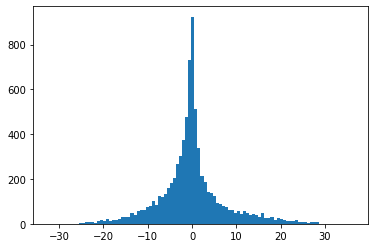

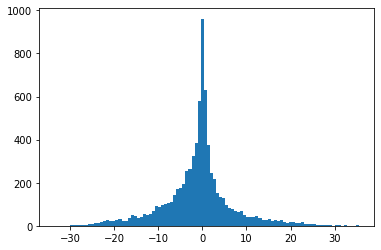

In [40]:
plt.hist(df_reg2.discr, bins=100)
plt.show()
plt.hist(df_reg2.discr_logit, bins=100)
plt.show()

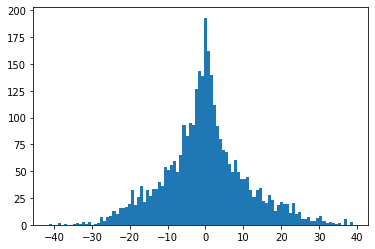

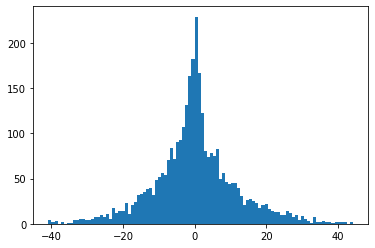

In [41]:
plt.hist(df_reg3.discr, bins=100)
plt.show()
plt.hist(df_reg3.discr_logit, bins=100)
plt.show()

# Regression Segment 2 and 3 (Review combined result)

## Calculate discrepancy

Keep Regression results only for correct classes (reg2 for '2' and '2?', reg3 for '3' and '3?')

In [42]:
df.loc[df['y_pred'].isin(['3','3?','4+']),['y_pred_reg2','y_pred_reg2_logit']]=np.nan
df.loc[df['y_pred'].isin(['2','2?','4+']),['y_pred_reg3','y_pred_reg3_logit']]=np.nan

In [43]:
df['discr_reg2']=df.amount-df.y_pred_reg2
df['discr_reg2_abs']=abs(df.amount-df.y_pred_reg2)
df['discr_reg2_logit']=df.amount-df.y_pred_reg2_logit
df['discr_reg2_logit_abs']=abs(df.amount-df.y_pred_reg2_logit)
df['discr_reg3']=df.amount-df.y_pred_reg3
df['discr_reg3_abs']=abs(df.amount-df.y_pred_reg3)
df['discr_reg3_logit']=df.amount-df.y_pred_reg3_logit
df['discr_reg3_logit_abs']=abs(df.amount-df.y_pred_reg3_logit)

In [45]:
df.loc[df.y_pred!='4+',['amount', 'amount_segment', 
    'y', 'y_pred', 
    'y_pred_reg2', 'discr_reg2', 'discr_reg2_abs', 
    'y_pred_reg2_logit', 'discr_reg2_logit',   'discr_reg2_logit_abs',
    'y_pred_reg3', 'discr_reg3', 'discr_reg3_abs',
    'y_pred_reg3_logit', 'discr_reg3_logit','discr_reg3_logit_abs'
   ]]

,amount,amount_segment,y,y_pred,y_pred_reg2,discr_reg2,discr_reg2_abs,y_pred_reg2_logit,discr_reg2_logit,discr_reg2_logit_abs,y_pred_reg3,discr_reg3,discr_reg3_abs,y_pred_reg3_logit,discr_reg3_logit,discr_reg3_logit_abs
ID,,,,,,,,,,,,,,,,
10663818,12.24,2.0,2,2,13.254559,-1.014559,1.014559,11.818873,0.421127,0.421127,NaN,NaN,NaN,NaN,NaN,NaN
11656520,46.10,2.0,2,2,41.985634,4.114366,4.114366,46.977623,-0.877623,0.877623,NaN,NaN,NaN,NaN,NaN,NaN
10567954,21.80,2.0,2,2,17.653545,4.146455,4.146455,31.589743,-9.789743,9.789743,NaN,NaN,NaN,NaN,NaN,NaN
11316833,18.64,2.0,2,2,19.096075,-0.456075,0.456075,17.517912,1.122088,1.122088,NaN,NaN,NaN,NaN,NaN,NaN
10468002,36.88,2.0,2,2,37.290569,-0.410569,0.410569,42.052727,-5.172727,5.172727,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11871755,24.84,2.0,2,3,NaN,NaN,NaN,NaN,NaN,NaN,58.646408,-33.806408,33.806408,52.399876,-27.559876,27.559876
12012664,18.84,2.0,2,2,32.679218,-13.839218,13.839218,37.579845,-18.739845,18.739845,NaN,NaN,NaN,NaN,NaN,NaN
10471275,11.02,2.0,2,2,11.782317,-0.762317,0.762317,10.568561,0.451439,0.451439,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
print('Discrepancy reg2, for predicted 2 and 2?')
print(df[df.y_pred.isin(['2','2?'])].discr_reg2.describe())
print('')
print('Discrepancy reg2, for predicted 2')
print(df[df.y_pred.isin(['2'])].discr_reg2.describe())
print('')
print('Absolute discrepancy reg2, for predicted 2 and 2?')
print(df[df.y_pred.isin(['2','2?'])].discr_reg2_abs.describe())
print('')
print('Absolute discrepancy reg2, for predicted 2')
print(df[df.y_pred.isin(['2'])].discr_reg2_abs.describe())

Discrepancy reg2, for predicted 2 and 2?
count    6643.000000
mean        6.490500
std        47.452306
min       -30.661981
25%        -2.301453
50%        -0.011883
75%         3.165420
max      2417.295993
Name: discr_reg2, dtype: float64

Discrepancy reg2, for predicted 2
count    5987.000000
mean        4.435938
std        33.215648
min       -30.661981
25%        -2.290122
50%        -0.079852
75%         2.111733
max      1115.306846
Name: discr_reg2, dtype: float64

Absolute discrepancy reg2, for predicted 2 and 2?
count    6643.000000
mean       10.442046
std        46.741861
min         0.000003
25%         0.784245
50%         2.563966
75%         7.833612
max      2417.295993
Name: discr_reg2_abs, dtype: float64

Absolute discrepancy reg2, for predicted 2
count    5987.000000
mean        8.322004
std        32.460634
min         0.000003
25%         0.690600
50%         2.211652
75%         6.599495
max      1115.306846
Name: discr_reg2_abs, dtype: float64


In [47]:
print('Discrepancy reg3, for predicted 3 and 3?')
print(df[df.y_pred.isin(['3','3?'])].discr_reg3.describe())
print('')
print('Discrepancy reg3, for predicted 3')
print(df[df.y_pred.isin(['3'])].discr_reg3.describe())
print('')
print('Absolute discrepancy reg3, for predicted 3 and 3?')
print(df[df.y_pred.isin(['3','3?'])].discr_reg3_abs.describe())
print('')
print('Absolute discrepancy reg3, for predicted 3')
print(df[df.y_pred.isin(['3'])].discr_reg3_abs.describe())

Discrepancy reg3, for predicted 3 and 3?
count     1757.000000
mean        11.558712
std        344.009782
min        -70.174307
25%         -9.190269
50%         -0.783471
75%          3.094766
max      10112.746093
Name: discr_reg3, dtype: float64

Discrepancy reg3, for predicted 3
count    1210.000000
mean        3.446868
std        71.951300
min       -70.174307
25%        -4.315473
50%        -0.065489
75%         3.120191
max      2186.270532
Name: discr_reg3, dtype: float64

Absolute discrepancy reg3, for predicted 3 and 3?
count     1757.000000
mean        28.747064
std        343.000796
min          0.000034
25%          1.730191
50%          5.634571
75%         17.624260
max      10112.746093
Name: discr_reg3_abs, dtype: float64

Absolute discrepancy reg3, for predicted 3
count    1210.000000
mean       13.293943
std        70.795517
min         0.000034
25%         1.265131
50%         3.743575
75%        10.178663
max      2186.270532
Name: discr_reg3_abs, dtype: float64


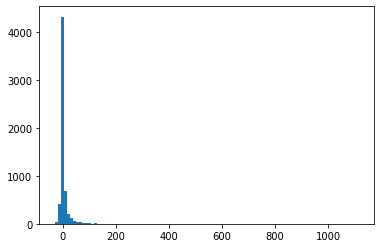

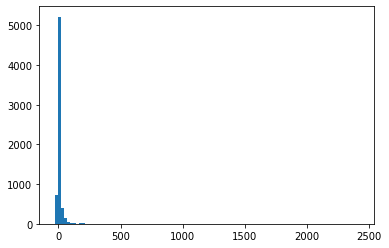

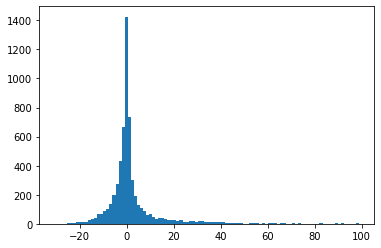

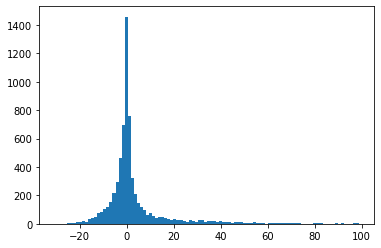

In [48]:
plt.hist(df[(df.y_pred.isin(['2']))].discr_reg2, bins=100)
plt.show()
plt.hist(df[(df.y_pred.isin(['2','2?']))].discr_reg2, bins=100)
plt.show()

plt.hist(df[(df.y_pred.isin(['2']))&(df.discr_reg2_abs<=100)].discr_reg2, bins=100)
plt.show()
plt.hist(df[(df.y_pred.isin(['2','2?']))&(df.discr_reg2_abs<=100)].discr_reg2, bins=100)
plt.show()



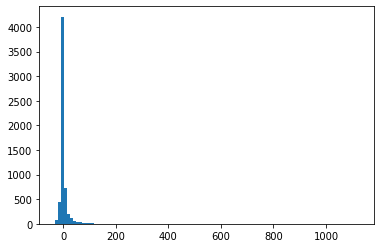

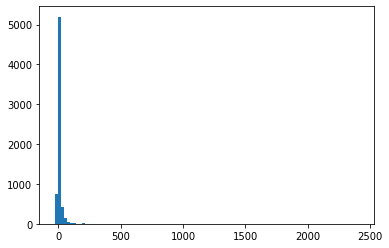

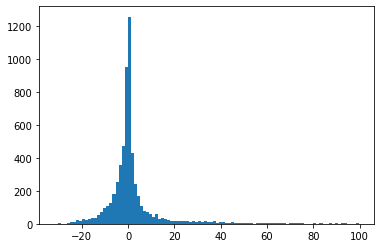

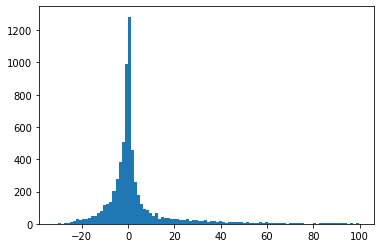

In [49]:
plt.hist(df[(df.y_pred.isin(['2']))].discr_reg2_logit, bins=100)
plt.show()
plt.hist(df[(df.y_pred.isin(['2','2?']))].discr_reg2_logit, bins=100)
plt.show()

plt.hist(df[(df.y_pred.isin(['2']))&(df.discr_reg2_logit_abs<=100)].discr_reg2_logit, bins=100)
plt.show()
plt.hist(df[(df.y_pred.isin(['2','2?']))&(df.discr_reg2_logit_abs<=100)].discr_reg2_logit, bins=100)
plt.show()



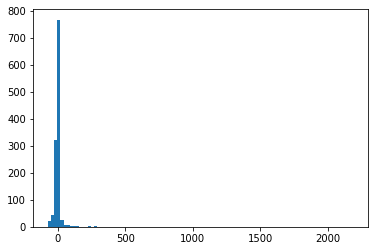

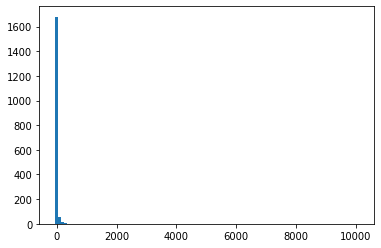

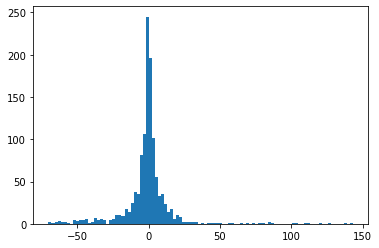

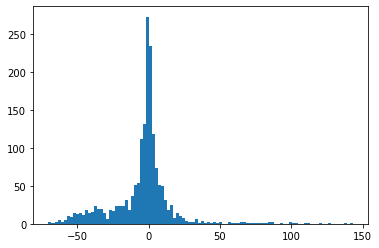

In [50]:
plt.hist(df[(df.y_pred.isin(['3']))].discr_reg3, bins=100)
plt.show()
plt.hist(df[(df.y_pred.isin(['3', '3?']))].discr_reg3, bins=100)
plt.show()

plt.hist(df[(df.y_pred.isin(['3']))&(df.discr_reg3_abs<=150)].discr_reg3, bins=100)
plt.show()
plt.hist(df[(df.y_pred.isin(['3','3?']))&(df.discr_reg3_abs<=150)].discr_reg3, bins=100)
plt.show()



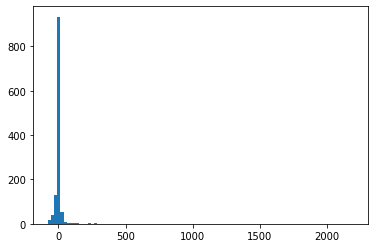

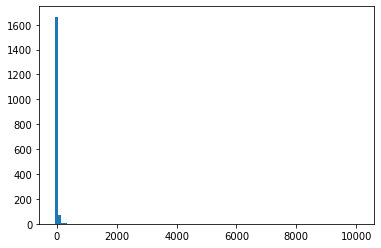

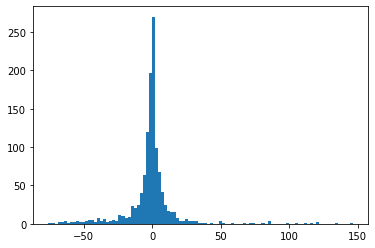

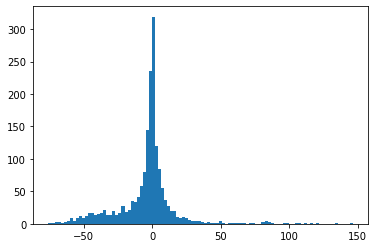

In [51]:
plt.hist(df[(df.y_pred.isin(['3']))].discr_reg3_logit, bins=100)
plt.show()
plt.hist(df[(df.y_pred.isin(['3', '3?']))].discr_reg3_logit, bins=100)
plt.show()

plt.hist(df[(df.y_pred.isin(['3']))&(df.discr_reg3_logit_abs<=150)].discr_reg3_logit, bins=100)
plt.show()
plt.hist(df[(df.y_pred.isin(['3','3?']))&(df.discr_reg3_logit_abs<=150)].discr_reg3_logit, bins=100)
plt.show()



# Feature Importance

## Feature importance

### CLF1

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


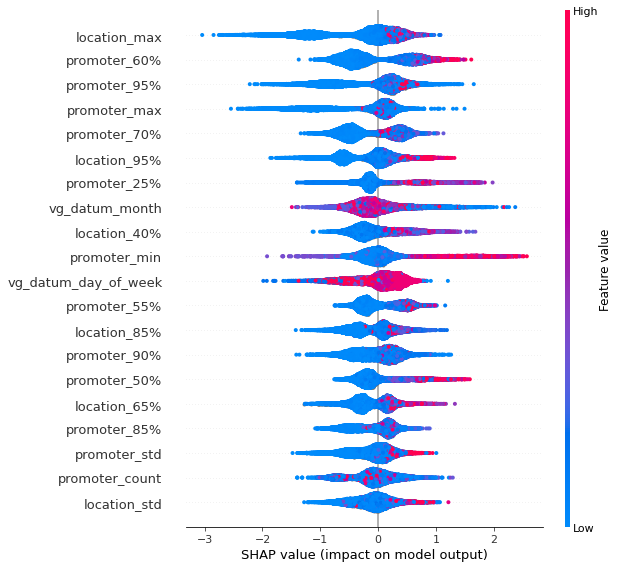

In [54]:
explainer_clf1 = shap.TreeExplainer(clf1)
shap_values_clf1 = explainer_clf1.shap_values(df[all_features])
shap.summary_plot(shap_values_clf1, features=df[all_features], feature_names=df[all_features].columns)

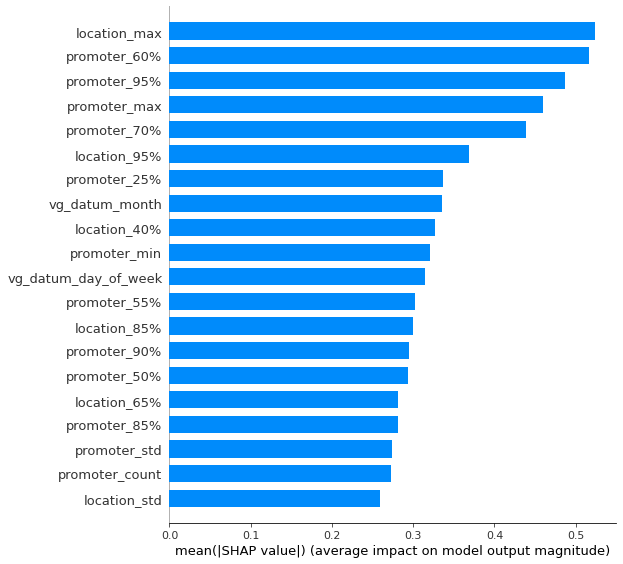

In [55]:
shap.summary_plot(shap_values_clf1, features=df[all_features], feature_names=df[all_features].columns, plot_type='bar')

### Feature importance CLF2

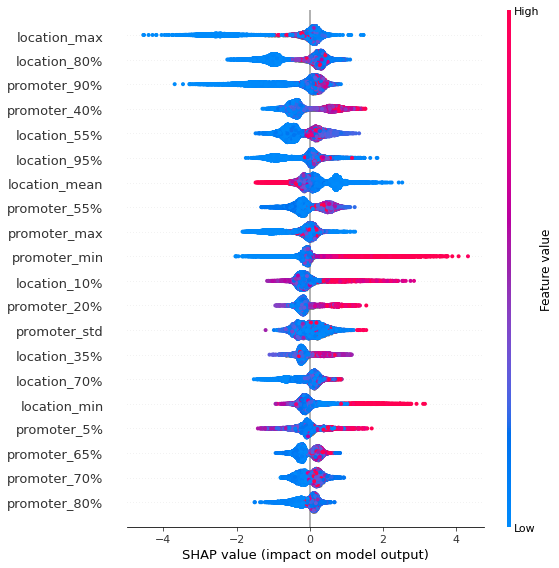

In [56]:
explainer_clf2 = shap.TreeExplainer(clf2)
shap_values_clf2 = explainer_clf2.shap_values(df[~df.y_clf2.isnull()][all_features])
shap.summary_plot(shap_values_clf2, features=df[~df.y_clf2.isnull()][all_features], feature_names=df[all_features].columns)

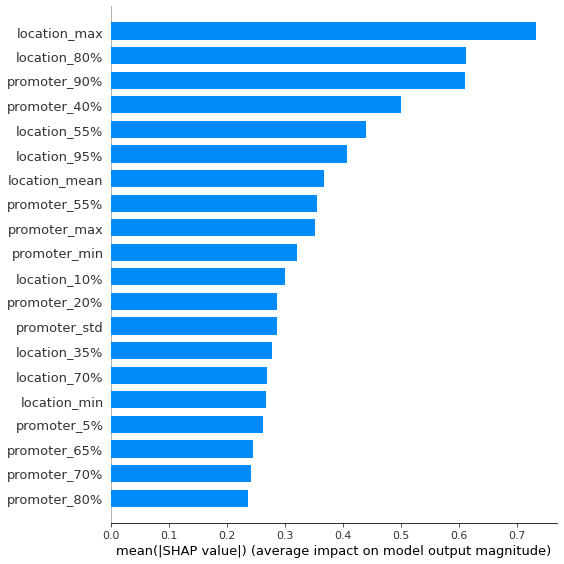

In [57]:
shap.summary_plot(shap_values_clf2, features=df[~df.y_clf2.isnull()][all_features], feature_names=df[all_features].columns, plot_type='bar')

### Feature Importance Reg2

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


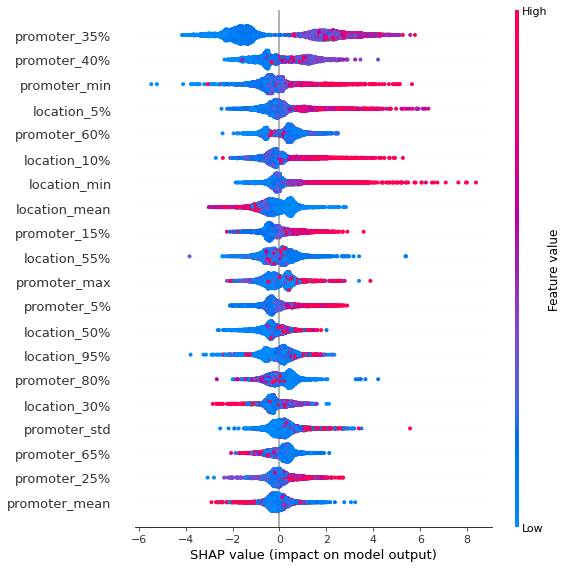

In [58]:
explainer_reg2 = shap.TreeExplainer(reg2)
shap_values_reg2 = explainer_reg2.shap_values(df[df.amount_segment==2][all_features])
shap.summary_plot(shap_values_reg2, features=df[df.amount_segment==2][all_features], feature_names=df[all_features].columns)

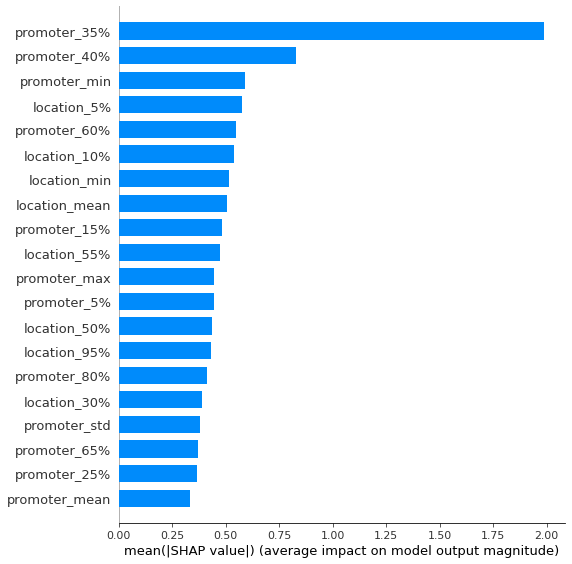

In [59]:
shap.summary_plot(shap_values_reg2, features=df[df.amount_segment==2][all_features], feature_names=df[all_features].columns, plot_type='bar')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


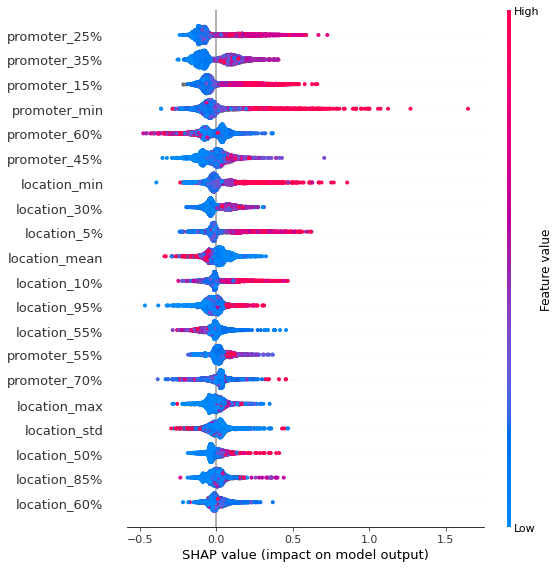

In [60]:
explainer_reg2_logit = shap.TreeExplainer(reg2_logit)
shap_values_reg2_logit = explainer_reg2_logit.shap_values(df[df.amount_segment==2][all_features])
shap.summary_plot(shap_values_reg2_logit, features=df[df.amount_segment==2][all_features], feature_names=df[all_features].columns)

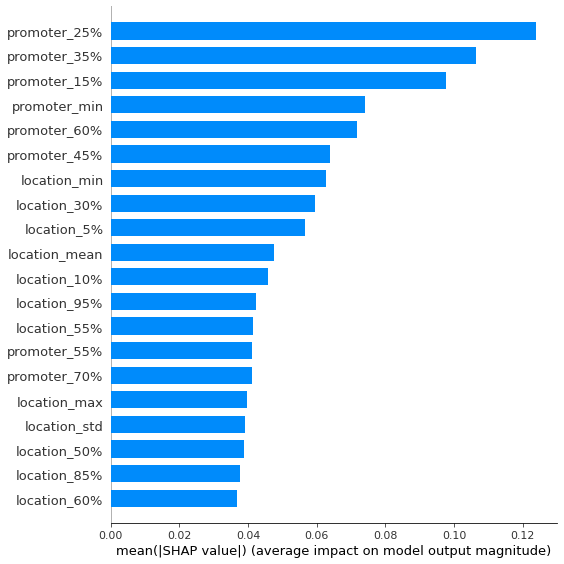

In [61]:
shap.summary_plot(shap_values_reg2_logit, features=df[df.amount_segment==2][all_features], feature_names=df[all_features].columns, plot_type='bar')

### Feature Importance reg3

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


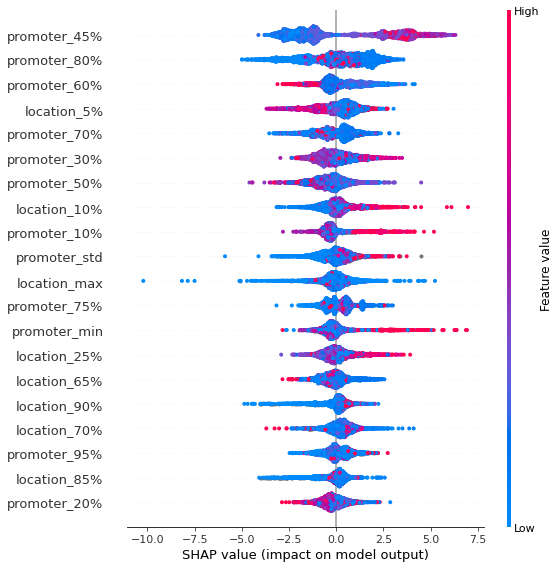

In [62]:
explainer_reg3 = shap.TreeExplainer(reg3)
shap_values_reg3 = explainer_reg3.shap_values(df[df.amount_segment==3][all_features])
shap.summary_plot(shap_values_reg3, features=df[df.amount_segment==3][all_features], feature_names=df[all_features].columns)

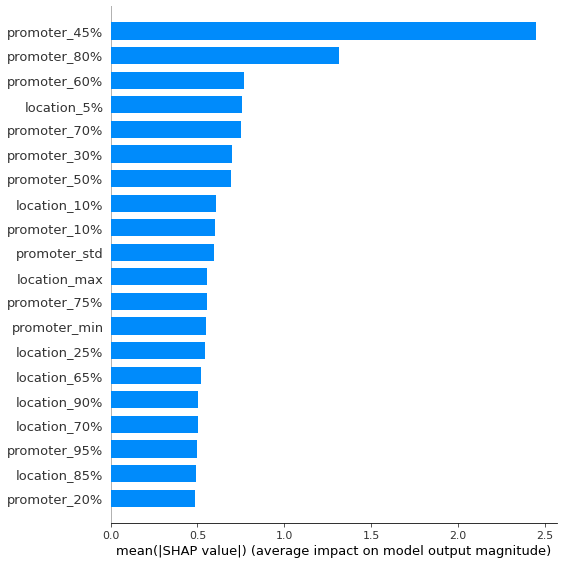

In [63]:
shap.summary_plot(shap_values_reg3, features=df[df.amount_segment==3][all_features], feature_names=df[all_features].columns, plot_type='bar')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


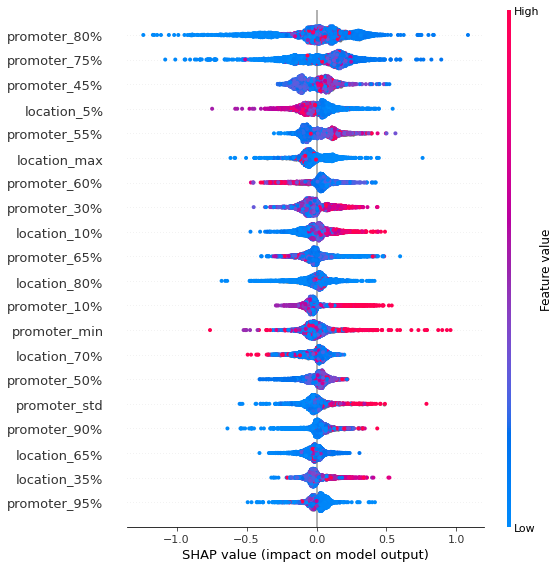

In [64]:
explainer_reg3_logit = shap.TreeExplainer(reg3_logit)
shap_values_reg3_logit = explainer_reg3_logit.shap_values(df[df.amount_segment==3][all_features])
shap.summary_plot(shap_values_reg3_logit, features=df[df.amount_segment==3][all_features], feature_names=df[all_features].columns)

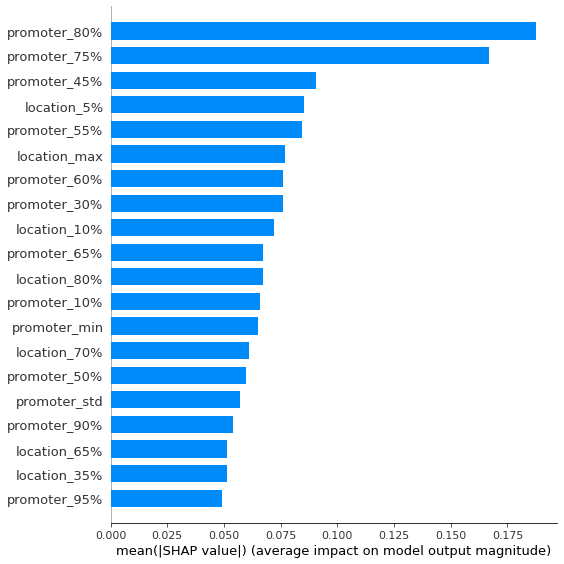

In [65]:
shap.summary_plot(shap_values_reg3_logit, features=df[df.amount_segment==3][all_features], feature_names=df[all_features].columns, plot_type='bar')

# Function

In [ ]:
def make_predict(df_features, clf1, clf2, reg1, reg2, t_neg1, t_neg2, t_pos2):
    prediction_result=pd.DataFrame(columns=['y_pred_proba_clf1',
                                           'y_pred_proba_clf2',
                                           'y_pred_clf1',
                                           'y_pred_clf2',
                                            'y_pred_reg2',
                                            'y_pred_reg3',
                                           'segment',
                                           'amount'])

    y_pred_proba_clf1 = clf1.predict_proba(df_features)[:, 1]
    y_pred_proba_clf2 = clf2.predict_proba(df_features)[:, 1]
    y_pred_reg2_logit=reg2.predict(df_features)
    y_pred_reg3_logit=reg3.predict(df_features)
    
    prediction_result.y_pred_proba_clf1=y_pred_proba_clf1
    prediction_result.y_pred_proba_clf2=y_pred_proba_clf2
    prediction_result.y_pred_reg2 = pd.Series(y_pred_reg2_logit).apply(expit)*50
    prediction_result.y_pred_reg3 = pd.Series(y_pred_reg3_logit).apply(expit)*50+50
    
    prediction_result['y_pred_proba_clf1']=prediction_result['y_pred_proba_clf1'].apply(lambda x: format(float(x),".8f")).astype(float)
    prediction_result['y_pred_proba_clf2']=prediction_result['y_pred_proba_clf2'].apply(lambda x: format(float(x),".8f")).astype(float)
    
    prediction_result['y_pred_clf1']=prediction_result['y_pred_proba_clf1'].apply(lambda x: '2 or 3' if x <= t_neg_clf1 else '4+')
    prediction_result['y_pred_clf2']=prediction_result['y_pred_proba_clf2'].apply(lambda x: '2' if x<=t_neg_clf2 else 
                                                ('2?' if x<=0.5 else 
                                                 ('3?' if x<=t_pos_clf2 else '3')))
    
    prediction_result['segment']=prediction_result.apply(lambda x: x['y_pred_clf1'] if x['y_pred_clf1']=='4+' else x['y_pred_clf2'], axis=1)

    prediction_result['amount']=prediction_result.apply(lambda x: 
                                                        x['y_pred_reg2'] if '2' in x.segment
                                                        else (x['y_pred_reg3'] if '3' in x.segment 
                                                        else np.nan), axis=1)
    
    prediction_result=prediction_result[['segment','amount']].copy()
    
    return prediction_result

In [ ]:
results=make_predict(df[all_features],clf1, clf2, reg2_logit, reg3_logit, 
             classifier_thresholds_clf1['t_neg_clf1'],
             classifier_thresholds_clf2['t_neg_clf2'],
             classifier_thresholds_clf2['t_pos_clf2'])
print(results.head(30))

In [ ]:
results[results.segment.isin(['2', '2?'])].amount.describe()

In [ ]:
results[results.segment.isin(['3','3?'])].amount.describe()